# **DIALOG ACT PREDICTOR USING DEEP NEURAL NETWORK**

<a name="Introduction"></a>
# Introduction
Natural Language Processing (NLP) is a field of study that focuses on the interaction between human language and computers. With the increasing availability of large text datasets and advances in machine learning algorithms, NLP has become a rapidly growing area of research with numerous applications in areas such as language translation, sentiment analysis, and speech recognition.

One important aspect of NLP is the ability to analyze and understand human dialogue, which can provide valuable insights into a wide range of topics such as consumer behavior, social trends, and public opinion. The DailyDialogue dataset is an example of a dataset that can be used to analyze and model natural human conversations.

In this project, we will explore the DailyDialogue dataset and use machine learning techniques to perform one or more NLP tasks such as sentiment analysis, topic modeling, or dialogue act classification. We will start by pre-processing the data and selecting an appropriate model architecture, and then train and evaluate the model using appropriate evaluation metrics. The results of this project will provide insights into the characteristics of the DailyDialogue dataset and demonstrate the effectiveness of machine learning techniques for analyzing and understanding natural human conversations.

<a name="Imports"></a>
# Importing Libraries

Importing all the python libraries which are needed to run the code used in this notebook.

In [ ]:
import requests
import zipfile
import os
import re
import nltk
import spacy
import contractions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from collections import Counter
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras import models, layers, utils
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint

<a name="DataAcquisition"></a>
# Data Acquisition
The purpose of Data Collection is that, it allows you to capture a record of past events so that we can use data analysis to find recurring patterns. For this task, we are going to use DailyDialog: A Manually Labelled Multi-turn Dialogue Dataset which is publicly available at [Link to dataset](http://yanran.li/dailydialog.html). Let's download the DailyDialog.zip file and extract file contents.

In [ ]:
def download_zip(file_link: str, zip_file_name: str):
  try:
    # Downloading zip file DailyDialog.zip
    r = requests.get(file_link, stream=True)
    with open(zip_file_name, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=128):
        fd.write(chunk)

  except FileNotFoundError as err:
    print(str(err))
    raise
  except Exception as err:
    print(str(err))
    raise

download_zip('http://yanran.li/files/ijcnlp_dailydialog.zip', 'ijcnlp_dailydialog.zip')

The below code defines a function extract_zip_contents that takes a nested zip file name as input and returns a list of tuples, where each tuple contains the filename and contents of a file within the nested zip file.

Then some pre-processing is done to extract contents and store in variables with the same names as files. Also, let's see what does each file has by printing readme.




In [ ]:
def extract_zip_contents(zip_filename):
  with zipfile.ZipFile(zip_filename) as zip_file:
    zip_contents = []
    for file in zip_file.namelist():
      if file.endswith('.zip'):
        # If the file is a nested zip file, recursively call this function to extract its contents
        zip_contents.extend(extract_zip_contents(zip_file.open(file)))
      else:
        # If the file is not a zip file, read its contents and append to the list of contents
        with zip_file.open(file) as f:
          zip_contents.append((file, f.read()))
    return zip_contents

zip_filename = 'ijcnlp_dailydialog.zip'
zip_contents = extract_zip_contents(zip_filename)
os.remove(zip_filename)
for file_extn, content in zip_contents:
  file_name = file_extn.split('/')[1]
  if file_name != '' and not file_name.startswith('.'):
    locals()[file_name.split('.')[0]] = content.decode('utf-8').splitlines()
for i in readme:
  print(i)

Here are some explanations about the files:

1) dialogues_text.txt: The DailyDialog dataset which contains 11,318 transcribed dialogues.
2) dialogues_topic.txt: Each line in dialogues_topic.txt corresponds to the topic of that in dialogues_text.txt.
                        The topic number represents: {1: Ordinary Life, 2: School Life, 3: Culture & Education,
                        4: Attitude & Emotion, 5: Relationship, 6: Tourism , 7: Health, 8: Work, 9: Politics, 10: Finance}
3) dialogues_act.txt: Each line in dialogues_act.txt corresponds to the dialog act annotations in dialogues_text.txt.
                      The dialog act number represents: { 1: inform，2: question, 3: directive, 4: commissive }
4) dialogues_emotion.txt: Each line in dialogues_emotion.txt corresponds to the emotion annotations in dialogues_text.txt.
                          The emotion number represents: { 0: no emotion, 1: anger, 2: disgust, 3: fear, 4: happiness, 5: sadness, 6: surprise}
5) train.zip, valid

<a name="Analysis"></a>
# Analysis and Processing of Data
Analysis and preprocessing of data are essential steps in NLP and other data-driven tasks. They involve understanding the data, cleaning it, and transforming it into a suitable format for analysis and modeling. These steps improve data quality, reduce noise, extract meaningful features, and enhance model performance, leading to more accurate results and valuable insights.

We aquired data above and saved as the following variables accordingly,
- dialogues_text
- dialogues_act
- dialogues_emotion
- dialogues_topic
- readme
- dialogues_test
- dialogues_act_test
- dialogues_emotion_test
- dialogues_train
- dialogues_act_train
- dialogues_emotion_train
- dialogues_validation
- dialogues_act_validation
- dialogues_emotion_validation

Let's check the length of the variables to make sure the files has same length of data.

In [ ]:
print("Length of Dialogues: " + str(len(dialogues_text)))
print("Length of Acts: " + str(len(dialogues_act)))
print("Length of Emotions: " + str(len(dialogues_emotion)))
print("Length of Topics: " + str(len(dialogues_topic)))

Length of Dialogues: 13118
Length of Acts: 13118
Length of Emotions: 13118
Length of Topics: 13118


As the files has same of data, let's create a pandas dataframe.

Pandas DataFrame is a widely-used data structure in Python for handling and analyzing structured data. It provides a two-dimensional table-like structure with labeled columns and rows. With Pandas DataFrame, one can easily manipulate, clean, and analyze data, perform indexing and selection operations, integrate with other data analysis tools, and handle large datasets efficiently. It is a popular choice for data scientists and analysts due to its versatility and powerful functionalities in data manipulation and analysis.

In [ ]:
# Creating a pandas dataframe
dialogues_df = pd.DataFrame({'dialogues': dialogues_text,
                             'acts': dialogues_act,
                             'emotions': dialogues_emotion,
                             'topics': dialogues_topic}
                            )

In [ ]:
# printing top 5 rows from the dataframe
dialogues_df.head()

,dialogues,acts,emotions,topics
0,The kitchen stinks . __eou__ I'll throw out th...,3 4,2 0,1
1,"So Dick , how about getting some coffee for to...",3 4 3 1 1,4 2 0 1 0,1
2,Are things still going badly with your housegu...,2 1 3 4,0 1 0 0,1
3,Would you mind waiting a while ? __eou__ Well ...,3 2 1 1,0 0 0 4,1
4,Are you going to the annual party ? I can give...,3 4 1,0 4 4,1


Looking at the dataframe, we can see that some rows has multiple dialogues, acts and emotions. Let's split the dialogues and create records in such a way that a record will have only one dialogue, act and emotion respectively.

To create separate records for each dialogue, act, emotion and topic, we are going to use the `zip()` function in Python to iterate over the corresponding values and create individual records.

This code will split the dialogues, acts, emotions and topics based on the delimiter (' __eou__ ' for dialogues and space for acts and emotions). Then, it iterates over the zipped values and creates separate records with the 'dialogue', 'act', and 'emotion' keys. Finally, the records are stored in a Pandas DataFrame.

In [ ]:
records = [] # List to store the records

# Iterate over each row in the DataFrame
for index, row in dialogues_df.iterrows():
  dialogues = row['dialogues'].split("__eou__") # Split the dialogues by "__eou__"
  acts = row['acts'].split(" ") # Split the acts by space
  emotions = row['emotions'].split(" ") # Split the emotions by space
  topics = [row['topics']] * len(dialogues) # Repeat the topic for each dialogue

  # Create records for each dialogue, act, emotion, and topic
  for dialogue, act, emotion, topic in zip(dialogues, acts, emotions, topics):
    if dialogue: # Check if the dialogue is not empty
      record = {'dialogues': dialogue, 'acts': act, 'emotions': emotion, 'topics': topic}
      records.append(record) # Append the record to the list of records

# Create DataFrame from the list of records
dialogues_df = pd.DataFrame(records)

# Replace empty strings in acts column with NaN
dialogues_df['acts'] = dialogues_df['acts'].replace(r'^s*$', float('NaN'), regex = True)

# Drop records which has NaN values
dialogues_df.dropna(inplace = True)

# Convert datatypes
dialogues_df['acts'] = pd.to_numeric(dialogues_df['acts'])
dialogues_df['emotions'] = pd.to_numeric(dialogues_df['emotions'])
dialogues_df['topics'] = pd.to_numeric(dialogues_df['topics'])

dialogues_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102979 entries, 0 to 102979
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   dialogues  102979 non-null  object
 1   acts       102979 non-null  int64 
 2   emotions   102979 non-null  int64 
 3   topics     102979 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.9+ MB


In [ ]:
# printing top 5 rows from the dataframe
dialogues_df.head()

,dialogues,acts,emotions,topics
0,The kitchen stinks .,3,2,1
1,I'll throw out the garbage .,4,0,1
2,"So Dick , how about getting some coffee for to...",3,4,1
3,Coffee ? I don ’ t honestly like that kind of...,4,2,1
4,"Come on , you can at least try a little , bes...",3,0,1


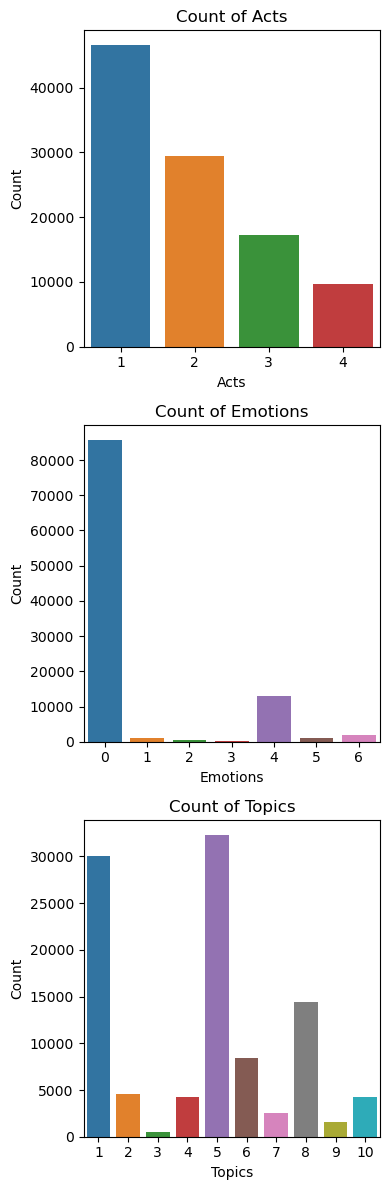

In [ ]:
# Create subplots with 3 rows and 1 column, and set the figure size
fig, ax = plt.subplots(3, 1, figsize=(4, 12))

# Plot the count of acts
ax1 = sns.countplot(x='acts', data=dialogues_df, ax=ax[0])
ax1.set_title('Count of Acts')  # Add a title to the plot
ax1.set_xlabel('Acts')  # Add a label to the x-axis
ax1.set_ylabel('Count')  # Add a label to the y-axis

# Plot the count of emotions
ax2 = sns.countplot(x='emotions', data=dialogues_df, ax=ax[1])
ax2.set_title('Count of Emotions')  # Add a title to the plot
ax2.set_xlabel('Emotions')  # Add a label to the x-axis
ax2.set_ylabel('Count')  # Add a label to the y-axis

# Plot the count of topics
ax3 = sns.countplot(x='topics', data=dialogues_df, ax=ax[2])
ax3.set_title('Count of Topics')  # Add a title to the plot
ax3.set_xlabel('Topics')  # Add a label to the x-axis
ax3.set_ylabel('Count')  # Add a label to the y-axis

# Adjust the spacing between the subplots
plt.tight_layout()

# Display the plot
plt.show()

<a name="HTML"></a>
## Removing HTML Tags
HTML tags are used to define the structure and formatting of web documents. When dealing with text data that contains HTML tags, it is often necessary to remove these tags to extract the clean text content. Removing HTML tags ensures that you are left with only the textual information for further analysis or processing.

We are going to use the BeautifulSoup library in Python to remove HTML tags from dialogues data.

In [ ]:
# Function to remove HTML tags from a text using BeautifulSoup
def remove_html_tags(text):

  # Create a BeautifulSoup object
  # text = open(text,'r')
  soup = BeautifulSoup(text, 'html.parser')

  # Extract the text without HTML tags
  text_without_tags = soup.get_text()
  cleaned_text = re.sub('\s+', ' ', text_without_tags)

  return cleaned_text

# Apply the remove_html_tags function to the 'dialogues' column
dialogues_df['dialogues'] = dialogues_df['dialogues'].apply(remove_html_tags)

/Users/rasagna/opt/anaconda3/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


<a name="Casefolding"></a>
## Case-Folding
Case-folding is a common preprocessing step in text analysis where all letters in the text are converted to lowercase. This helps to normalize the text and ensure that similar words with different cases are treated as the same word.

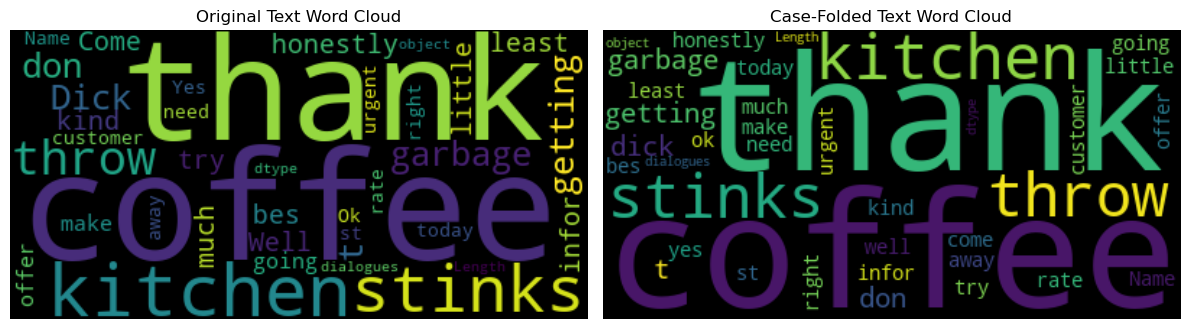

In [ ]:
# Function to convert text to lowercase
def to_lower(text):
    # Perform case-folding
    text = text.lower()

    return text

# Create word cloud for the original text
wordcloud_original = WordCloud().generate(str(dialogues_df['dialogues']))

# Apply the to_lower function to the 'dialogues' column
dialogues_df['dialogues'] = dialogues_df['dialogues'].apply(to_lower)

# Create word cloud for the case-folded text
wordcloud_case_folded = WordCloud().generate(str(dialogues_df['dialogues']))

# Plot the word clouds
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

axes[0].imshow(wordcloud_original, interpolation='bilinear')
axes[0].set_title('Original Text Word Cloud')
axes[0].axis('off')

axes[1].imshow(wordcloud_case_folded, interpolation='bilinear')
axes[1].set_title('Case-Folded Text Word Cloud')
axes[1].axis('off')

plt.tight_layout()
plt.show()

<a name="Whitespaces"></a>
## Removing Whitespaces
Removing whitespace helps ensure consistency, aids in tokenization, improves text matching accuracy, saves storage space, and facilitates parsing and analysis of the text.

In [ ]:
# Remove leading/trailing whitespace
def remove_whitespace(text):

  # Remove whitespace near single quotes
  text = re.sub(r'\s+(?=[’\'"])|(?<=[’\'"])\s+', '', text)  # Remove whitespace before and after single quote

  return text.strip()

# Apply the remove_whitespace function to the 'dialogues' column
dialogues_df['dialogues'] = dialogues_df['dialogues'].apply(remove_whitespace)
dialogues_df.head(5)

,dialogues,acts,emotions,topics
0,the kitchen stinks .,3,2,1
1,i'll throw out the garbage .,4,0,1
2,"so dick , how about getting some coffee for to...",3,4,1
3,coffee ? i don’t honestly like that kind of st...,4,2,1
4,"come on , you can at least try a little , besi...",3,0,1


<a name="Contractions"></a>
## Expanding Contractions
Contractions are shortened forms of words or phrases, where one or more letters are replaced with an apostrophe. For example, "can't" is a contraction of "cannot" and "I'm" is a contraction of "I am". Expanding contractions involves replacing these shortened forms with their full equivalents.

In [ ]:
# Expand contractions
def expand_contractions(text):
  return contractions.fix(text)

# Apply the expand_contractions function to the 'dialogues' column
dialogues_df['dialogues'] = dialogues_df['dialogues'].apply(expand_contractions)
dialogues_df.head(5)

,dialogues,acts,emotions,topics
0,the kitchen stinks .,3,2,1
1,i will throw out the garbage .,4,0,1
2,"so dick , how about getting some coffee for to...",3,4,1
3,coffee ? i do not honestly like that kind of s...,4,2,1
4,"come on , you can at least try a little , besi...",3,0,1


<a name="Punctuations"></a>
## Removing Punctuations
Punctuation marks such as periods, commas, exclamation marks, and question marks do not typically carry significant meaning in the context of text analysis and can be safely removed.

In [ ]:
# Remove punctuation
def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# Apply the remove_punctuation function to the 'dialogues' column
dialogues_df['dialogues'] = dialogues_df['dialogues'].apply(remove_punctuation)
dialogues_df.head(5)

,dialogues,acts,emotions,topics
0,the kitchen stinks,3,2,1
1,i will throw out the garbage,4,0,1
2,so dick how about getting some coffee for ton...,3,4,1
3,coffee i do not honestly like that kind of st...,4,2,1
4,come on you can at least try a little beside...,3,0,1


<a name="Tokenisation"></a>
## Tokenisation and Segmentation
Tokenization and segmentation are two fundamental steps in natural language processing. Both tokenization and segmentation are essential for preparing text data for NLP tasks. They enable the transformation of unstructured text into structured and manageable units, facilitating subsequent analysis, modeling, and interpretation of text data. Let's take a closer look at each of them:

**Tokenization:**
Tokenization is the process of breaking down a text into smaller units called tokens. These tokens can be words, characters, or subwords, depending on the level of granularity required. Tokenization serves as a fundamental step in various NLP tasks, such as text classification, machine translation, and sentiment analysis. The purpose of tokenization is to divide the text into meaningful units that can be processed and analyzed effectively.

Here we are doing Word Tokenization, Dividing the text into individual words.

**Segmentation:**
Segmentation refers to the process of dividing a text into segments or chunks based on specific criteria. Segmentation can be done at different levels, such as sentence segmentation, paragraph segmentation, or document segmentation.

However, our data already consists of short and segmented text, additional segmentation may not be necessary.

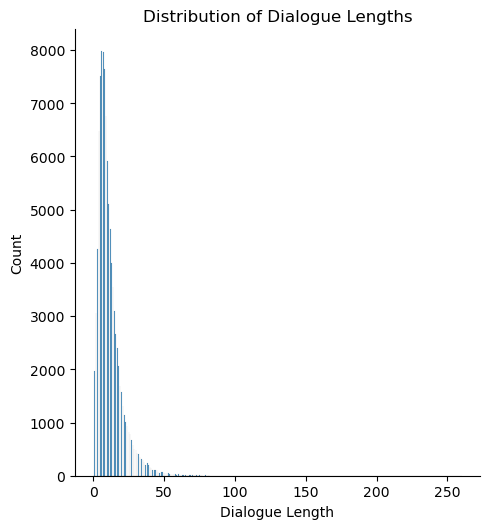

In [ ]:
# Tokenise the dialogues
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Apply the tokenize_text function to the 'dialogues' column
dialogues_df['dialogues'] = dialogues_df['dialogues'].apply(tokenize_text)

# Plot the distribution of dialogue lengths
seq_lengths = [len(dialogue) for dialogue in dialogues_df['dialogues']]
sns.displot(seq_lengths, kind='hist')
plt.title('Distribution of Dialogue Lengths')  # Add a title to the plot
plt.xlabel('Dialogue Length')  # Add a label to the x-axis
plt.ylabel('Count')  # Add a label to the y-axis
plt.show()

<a name="Stopwords"></a>
## Removing Stop Words

Stop words are commonly occurring words that do not provide any significant meaning to the text. These words are removed from the text to reduce the noise in the data and improve the model's accuracy.

In [ ]:
# Remove stop words
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

# Apply the remove_stopwords function to the 'dialogues' column
dialogues_df['dialogues'] = dialogues_df['dialogues'].apply(remove_stopwords)
dialogues_df.head()

,dialogues,acts,emotions,topics
0,"[kitchen, stinks]",3,2,1
1,"[throw, garbage]",4,0,1
2,"[dick, getting, coffee, tonight]",3,4,1
3,"[coffee, honestly, like, kind, stuff]",4,2,1
4,"[come, least, try, little, besides, cigarette]",3,0,1


<a name="Stemming"></a>
## Stemming and lemmatisation

**Stemming:** Stemming reduces words to their base or root forms by removing suffixes or prefixes. It is a more aggressive approach and can result in the reduction of words to non-dictionary forms. Stemming can be useful when you want to simplify the analysis by grouping related words together based on their stems. However, it may not always produce actual words.

**Lemmatisation:** Lemmatisation, on the other hand, produces valid words by considering the context and part of speech. It converts words to their base form using morphological analysis and dictionaries. Lemmatisation can provide more meaningful results, especially when you need to maintain the interpretability and grammatical correctness of words.

We want to prioritize maintaining meaningful and grammatically correct words, so lemmatisation would be more suitable. It will convert words to their base forms, making it easier to analyze and understand the text while preserving the interpretability of the words.

In [ ]:
# Lemmatise words
def lemmatise_words(tokens):
  # Perform lemmatization
  lemmatizer = WordNetLemmatizer()
  lemmatised_words = [lemmatizer.lemmatize(token) for token in tokens]

  return lemmatised_words

# Apply the lemmatise_words function to the 'dialogues' column
dialogues_df['dialogues'] = dialogues_df['dialogues'].apply(lemmatise_words)

In [ ]:
def pre_process(text,
                remove_html=False,
                to_lowe=False,
                remove_whitespac=False,
                expand_contraction=False,
                remove_punctuatio=False,
                remove_stop_word=False):
    if remove_html:
        text = remove_html_tags(text)
    if to_lowe:
        text = to_lower(text)
    if remove_whitespac:
        remove_whitespace(text)
    if expand_contraction:
        expand_contractions(text)
    if remove_punctuatio:
        remove_punctuation(text)
    tokens = tokenize_text(text)
    tokens = lemmatise_words(tokens)
    if remove_stop_word:
        remove_stopwords(tokens)

    return tokens

<a name="Vocabulary"></a>
## Creating Vocabulary

Creating a vocabulary allows us to reduce the dimensionality of the data, represent text as numeric features, and efficiently store and process the data. A vocabulary captures the most common words in the corpus, enabling generalization and control over the vocabulary size. Overall, creating a vocabulary helps in effectively representing and analyzing text data for various machine learning applications.

In [ ]:
def create_vocabulary(tokenized_sentences, vocab_size):
    word_counts = Counter() # Initialize a Counter to count word occurrences

     # Iterate over each tokenized sentence
    for sentence in tokenized_sentences:
        word_counts.update(sentence) # Update the word counts with the sentence tokens

    # Sort words by frequency in descending order
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Get the most common words up to the specified vocab_size
    common_words = [word for word, count in sorted_words[:vocab_size]]

    return common_words

vocab_size = 10000  # Adjust the vocab_size as desired
dialogue_vocab = create_vocabulary(dialogues_df['dialogues'], vocab_size)
print(dialogue_vocab[0:10]) # Print the first 10 words in the vocabulary

['like', 'would', 'yes', 'good', 'think', 'well', 'know', 'get', 'go', 'one']


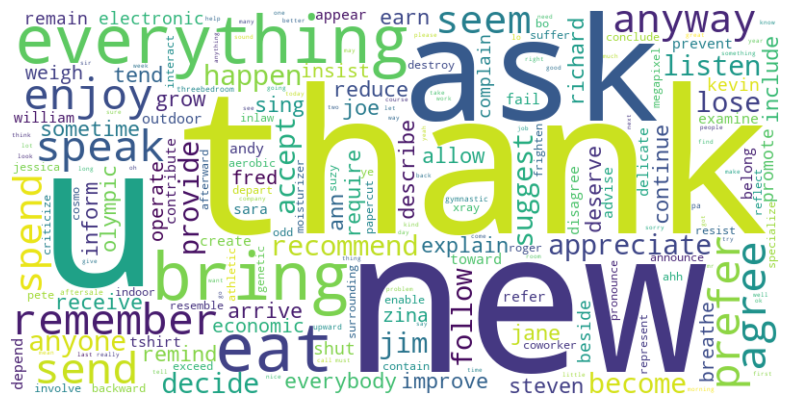

In [ ]:
# Convert the vocabulary into a string
vocab_text = ' '.join(dialogue_vocab)

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(vocab_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


<a name="Features"></a>
# Feature Extraction

Based on the dataset, the suitable representation technique would be TF-IDF.

**TF-IDF:** This is a text representation technique that assigns weights to words based on their frequency within a document and rarity across the entire corpus. It captures the importance of words in distinguishing documents and is commonly used for tasks like text classification. TF-IDF considers both local (term frequency) and global (inverse document frequency) importance of words, providing a more informative representation compared to simple word counts.

In [ ]:
dialogues_df['dialogues'] = dialogues_df['dialogues'].apply(lambda x: ' '.join(x))

# TF-IDF representation
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=vocab_size)
tfidf_features = tfidf_vectorizer.fit_transform(dialogues_df['dialogues'].values)

# Get tfidf feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert TF-IDF features to an array
tfidf_array = tfidf_features.toarray()

<a name="NN"></a>
# Neural Network

Here we are implementing a neural network model using Keras for multi-class classification. The model architecture consists of several dense layers with ReLU activation, followed by dropout regularization. The model is trained using the Adam optimizer and categorical cross-entropy loss. The accuracy of the model is evaluated on a separate testing set.

In [ ]:
# Features data
X = tfidf_array

# Label data
y = utils.to_categorical(dialogues_df['acts'].values, num_classes=5, dtype="int")

# Split the data into training, validation, and testing sets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

# Create a sequential model
nn_model = models.Sequential()

# Add the first dense layer with 64 units and ReLU activation
nn_model.add(layers.Dense(64, activation="relu", input_shape=(vocab_size, )))
nn_model.add(layers.Dropout(0.2)) # Dropout to prevent overfitting

# Add the second dense layer with 32 units and ReLU activation
nn_model.add(layers.Dense(32, activation="relu"))
nn_model.add(layers.Dropout(0.2)) # Dropout to prevent overfitting

# Add the third dense layer with 16 units and ReLU activation
nn_model.add(layers.Dense(16, activation="relu"))
nn_model.add(layers.Dropout(0.2)) # Dropout to prevent overfitting

# Add the output layer with 5 units (for 5 classes) and softmax activation
nn_model.add(layers.Dense(5, activation="softmax"))

# Compile the model with adam optimizer, categorical cross-entropy loss, and accuracy metric
nn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print a summary of the model architecture
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 8

2023-05-16 12:13:09.017499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Epochs:** Increasing the number of epochs allows the model to see the training data multiple times and learn from it. However, setting a higher number of epochs does not always guarantee better performance and can lead to overfitting. The choice of 30 epochs in this code is based on empirical observation of the model's convergence and validation performance.

**Batch size:** Batch size refers to the number of training samples processed before updating the model's parameters. Larger batch sizes can provide computational efficiency, as they allow for parallel processing and take better advantage of hardware resources. On the other hand, smaller batch sizes can introduce more randomness into the parameter updates and potentially help the model generalize better. A batch size of 64 in this code is a reasonable balance between computational efficiency and model convergence, considering the dataset size.

In [ ]:
# Train the model
trained_nn_model = nn_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/50
564/564 [==============================] - 4s 7ms/step - loss: 1.1663 - accuracy: 0.5131 - val_loss: 0.9878 - val_accuracy: 0.5943
Epoch 2/50
564/564 [==============================] - 3s 5ms/step - loss: 0.9380 - accuracy: 0.6233 - val_loss: 0.9561 - val_accuracy: 0.6052
Epoch 3/50
564/564 [==============================] - 3s 5ms/step - loss: 0.8474 - accuracy: 0.6631 - val_loss: 0.9614 - val_accuracy: 0.6113
Epoch 4/50
564/564 [==============================] - 3s 5ms/step - loss: 0.7748 - accuracy: 0.6922 - val_loss: 0.9839 - val_accuracy: 0.6153
Epoch 5/50
564/564 [==============================] - 3s 6ms/step - loss: 0.7120 - accuracy: 0.7184 - val_loss: 1.0288 - val_accuracy: 0.6142
Epoch 6/50
564/564 [==============================] - 3s 6ms/step - loss: 0.6521 - accuracy: 0.7424 - val_loss: 1.0972 - val_accuracy: 0.6169
Epoch 7/50
564/564 [==============================] - 3s 5ms/step - loss: 0.5947 - accuracy: 0.7649 - val_loss: 1.1649 - val_accuracy: 0.6191
Epoch 

In [ ]:
# Get the accuracy history during training
trained_nn_accuracy = trained_nn_model.history["accuracy"]

# Make predictions on the test set
nn_model_y_pred = nn_model.predict(X_test)
nn_model_y_pred_multi = np.argmax(nn_model_y_pred, axis=1)

# Calculate the test accuracy
test_acc = accuracy_score(np.argmax(y_test,axis=1), nn_model_y_pred_multi)

# Print the final accuracy
print("Accuracy:", round(trained_nn_accuracy[-1] * 100, 2))

483/483 [==============================] - 1s 823us/step
Accuracy: 90.16


<a name="Hyperparameters1"></a>
## Selecting Hyperparameters

We tuned the following hyperparameters of the MLPClassifier model:

1. `hidden_layer_sizes`: This parameter controls the number of neurons in the hidden layers of the neural network. We explored different options such as (64,), (128,), and (256,) to find the optimal number of neurons in the hidden layers.

2. `activation`: This parameter determines the activation function used in the neural network. We considered two options: 'relu' and 'tanh'. 'relu' stands for Rectified Linear Unit, while 'tanh' represents the hyperbolic tangent function. By tuning this parameter, we can evaluate which activation function performs better for our specific task.

3. `alpha`: This parameter controls the regularization strength of the neural network. It represents the L2 penalty (weight decay) term that helps prevent overfitting. We tested different values such as 0.0001, 0.001, and 0.01 to find an optimal level of regularization.

These hyperparameters were tuned to find the combination that maximizes the model's performance in terms of accuracy. By exploring different values for these hyperparameters, we can identify the settings that result in the best trade-off between model complexity and generalization ability.

In [ ]:
# Define the parameter search space for random search
param_space = {
    'hidden_layer_sizes': [(64,), (128,), (256,)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Create the base model
base_model = MLPClassifier(random_state=42)

# Perform random search with cross-validation
random_search = RandomizedSearchCV(estimator=base_model,
                                   param_distributions=param_space,
                                   cv=5,
                                   n_iter=1,
                                   scoring='accuracy',
                                   random_state=42,
                                   n_jobs=-1)

# Split the data into training, validation, and testing sets
X_train, X_rem, y_train, y_rem = train_test_split(X[:3000], y[:3000], test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

print(best_params)

/Users/rasagna/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rasagna/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rasagna/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rasagna/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rasagna/o

{'hidden_layer_sizes': (64,), 'alpha': 0.0001, 'activation': 'relu'}


/Users/rasagna/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<a name="RFModel"></a>
# Multi Label Classifier

The high-level model architecture in the provided code is a multi-output classifier using the Random Forest algorithm. The input features are obtained using the TF-IDF representation of the dialogue data. The labels consist of three categories: acts, emotions, and topics. The labels are combined into a single array and split into training and validation sets. The training labels are then unzipped into separate arrays. The multi-output classifier is trained using the training features and labels. Predictions are made on the validation set using the trained classifier. The predicted labels are unzipped back into separate arrays, and accuracy scores are calculated for each label category using the actual and predicted labels. The overall validation set accuracy is printed at the end.

In [ ]:
# features and labels
features = tfidf_features[:30000]
acts = dialogues_df['acts'][:30000]
emotions = dialogues_df['emotions'][:30000]
topics = dialogues_df['topics'][:30000]

# Combine acts, emotions, and topics into a single labels array
labels = list(zip(acts, emotions, topics))

# Split the data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Unzip the training labels back into separate arrays
train_acts, train_emotions, train_topics = zip(*train_labels)

# Create a multi-output classifier (using Random Forest as an example)
classifier = MultiOutputClassifier(RandomForestClassifier())

# Train the multi-output classifier
classifier.fit(train_features, train_labels)

# Make predictions on the validation set
predictions = classifier.predict(val_features)

# Unzip the predicted labels back into separate arrays
predicted_acts, predicted_emotions, predicted_topics = zip(*predictions)

# Calculate accuracy for each label
val_acts, val_emotions, val_topics = zip(*val_labels)
act_accuracy = accuracy_score(val_acts, predicted_acts)
emotion_accuracy = accuracy_score(val_emotions, predicted_emotions)
topic_accuracy = accuracy_score(val_topics, predicted_topics)

print("Validation Accuracy: " + str(emotion_accuracy * 100))

Validation Accuracy: 88.46666666666667


<a name="Hyperparameters"></a>
## Selecting Hyperparameters

Hyperparameter tuning is the process of finding the optimal values for the hyperparameters of a machine learning model. Hyperparameters are settings that are not learned from the data but are set before the training process, such as learning rate, regularization strength, number of hidden layers, etc. The goal of hyperparameter tuning is to improve the performance of the model by finding the best combination of hyperparameters.

Here we are going to do Randomised Search. Random Search randomly picks samples from the hyperparameter space.

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
classifier = RandomForestClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(classifier, param_distributions=param_grid, n_iter=1, cv=5, scoring='accuracy')

# Perform the hyperparameter search
random_search.fit(train_features, train_emotions)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_model = RandomForestClassifier(**best_params)
best_model.fit(train_features, train_emotions)

# Evaluate the model on the validation set
val_predictions = best_model.predict(val_features)
val_accuracy = accuracy_score(val_emotions, val_predictions)
print("Validation Accuracy: ", val_accuracy)

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
Validation Accuracy:  0.838


<a name="Evaluation"></a>
# Evaluating the Models and Results

To evaluate the performance of a classification model, we can use various evaluation metrics.

Confusion matrix compares the ground truth to the predicted label and classifies the results into True Positive, True Negative, False Positive and False Negative. To plot the confusion matrix, we simply call the plot_confusion_matrix method.

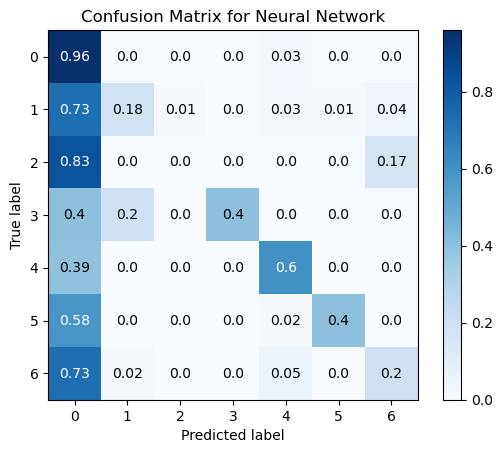

In [ ]:

skplt.metrics.plot_confusion_matrix(val_emotions, predicted_emotions, normalize=True, title = 'Confusion Matrix for Neural Network');



In [ ]:
input_dialogue = "He is not crazy"

# Preprocess the input dialogue (tokenize, remove stopwords, etc.)
processed_dialogue = pre_process(input_dialogue, True, True, True, True, True, True)

# Convert the processed dialogue to a feature vector using TF-IDF
input_features = tfidf_vectorizer.transform([input_dialogue])

# Make the act prediction
predicted_act = np.argmax(nn_model.predict(input_features), axis=1)

# Mapping of act labels
act_labels = { 1: 'inform', 2: 'question', 3: 'directive', 4: 'commissive' }

# Get the predicted act label
predicted_act_label = act_labels[predicted_act[0]]
print("Predicted Act:", predicted_act_label)

1/1 [==============================] - 0s 86ms/step
Predicted Act: inform
